In [1]:
%load_ext autoreload
%autoreload 2

import sys
if sys.path[-1] != "..": sys.path.append("..")

from qBN.qBNMC import qBayesNet
from qBN.qBNRejection import qInference
from qBN.qBNRT import qRuntime

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import matplotlib.pyplot as plt

import numpy as np

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33'
)

backend = service.get_backend("ibm_brisbane")

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33')

In [3]:
bn1 = gum.fastBN("A->B<-C", 2)
bn1.cpt("A")[:] = [0.05, 0.95]
bn1.cpt("C")[:] = [0.05, 0.95]
bn1.cpt("B")[:] = [[[0.1, 0.9], [0.2, 0.8]], [[0.3, 0.7], [0.4, 0.6]]]
qbn1 = qBayesNet(bn1)

In [4]:
ev1 = {"A": 0, "C":0}
tn1 = "B"
value_range = range(100,1000,100)

In [5]:
qinf1 = qInference(qbn1)
qinf1.setEvidence(ev1)
qinf1.useFragmentBN(target={tn1})
qinf1.getGates()

In [6]:
ie1 = gum.LazyPropagation(bn1)
ie1.setEvidence(ev1)
ie1.makeInference()

In [7]:
nb_obs = 10

In [8]:
mc1_max_err = list()

for j in range(nb_obs):
    mc1_max_err.append(list())
    for i in value_range:

        mc1 = gum.MonteCarloSampling(bn1)
        mc1.setEvidence(ev1)
        mc1.setEpsilon(1e-10)
        mc1.setMaxTime(1e10)
        mc1.setMaxIter(i)
        mc1.makeInference()

        offset = mc1.posterior(tn1).toarray() - ie1.posterior(tn1).toarray()
        max_offset = offset.max()
        mc1_max_err[j].append(max_offset)

mc1_max_err = np.array(mc1_max_err)

In [9]:
qinf1_max_err = list()

for j in range(nb_obs):
    qinf1_max_err.append(list())
    print(f"Run number {j} -", end=' ')
    for i in value_range:

        qinf1.setMaxIter(i)
        qinf1.makeInference()

        offset = qinf1.posterior(tn1).toarray() - ie1.posterior(tn1).toarray()
        max_offset = offset.max()
        qinf1_max_err[j].append(max_offset)

        print(f"{i}: {max_offset:.4f}", end=', ')
    print()

qinf1_max_err = np.array(qinf1_max_err)

Run number 0 - 100: 0.0300, 200: 0.0050, 300: 0.0100, 400: 0.0000, 500: 0.0020, 600: 0.0117, 700: 0.0029, 800: 0.0113, 900: 0.0078, 
Run number 1 - 100: 0.0000, 200: 0.0050, 300: 0.0200, 400: 0.0025, 500: 0.0000, 600: 0.0133, 700: 0.0057, 800: 0.0063, 900: 0.0133, 
Run number 2 - 100: 0.0400, 200: 0.0250, 300: -0.0000, 400: 0.0025, 500: 0.0260, 600: 0.0117, 700: 0.0029, 800: 0.0063, 900: 0.0156, 
Run number 3 - 100: 0.0200, 200: 0.0350, 300: 0.0233, 400: 0.0025, 500: 0.0120, 600: 0.0100, 700: 0.0029, 800: 0.0112, 900: 0.0122, 
Run number 4 - 100: 0.0200, 200: 0.0300, 300: 0.0167, 400: 0.0025, 500: 0.0120, 600: 0.0117, 700: 0.0286, 800: 0.0013, 900: 0.0044, 
Run number 5 - 100: 0.0100, 200: 0.0000, 300: -0.0000, 400: 0.0050, 500: 0.0020, 600: 0.0033, 700: 0.0157, 800: 0.0037, 900: 0.0033, 
Run number 6 - 100: 0.0100, 200: 0.0200, 300: 0.0100, 400: 0.0075, 500: 0.0120, 600: 0.0117, 700: 0.0171, 800: 0.0150, 900: 0.0089, 
Run number 7 - 100: 0.0100, 200: 0.0250, 300: 0.0100, 400: 0.0125, 

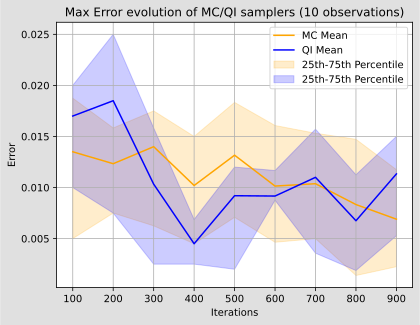

In [10]:
mc1_mean = np.mean(mc1_max_err, axis=0)
mc1_percentile_25 = np.percentile(mc1_max_err, 25, axis=0)
mc1_percentile_75 = np.percentile(mc1_max_err, 75, axis=0)

qinf1_mean = np.mean(qinf1_max_err, axis=0)
qinf1_percentile_25 = np.percentile(qinf1_max_err, 25, axis=0)
qinf1_percentile_75 = np.percentile(qinf1_max_err, 75, axis=0)


plt.plot(value_range, mc1_mean, label='MC Mean', color='orange')
plt.plot(value_range, qinf1_mean, label='QI Mean', color='blue')

plt.fill_between(value_range, mc1_percentile_25, mc1_percentile_75, color='orange', alpha=0.2, label='25th-75th Percentile')
plt.fill_between(value_range, qinf1_percentile_25, qinf1_percentile_75, color='blue', alpha=0.2, label='25th-75th Percentile')

plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title(f'Max Error evolution of MC/QI samplers ({nb_obs} observations)')
plt.legend()
plt.grid(True)

plt.savefig('ErrEvoIter.png')
plt.show()

In [11]:
qrt1 = qRuntime(qinf1, backend)
qrt1.getGateExecutionTime()
A_time = qrt1.A_time
G_time = qrt1.G_time

In [12]:
nb_obs = 10

In [13]:
mc1_time = list()

for j in range(nb_obs):
    mc1_time.append(list())
    for i in value_range:

        mc1 = gum.MonteCarloSampling(bn1)
        mc1.setEvidence(ev1)
        mc1.setEpsilon(1e-10)
        mc1.setMaxTime(1e10)
        mc1.setMaxIter(i)
        mc1.makeInference()

        mc1_time[j].append(mc1.currentTime())

mc1_time = np.array(mc1_time)

In [14]:
qinf1_time = list()

for j in range(nb_obs):
    qinf1_time.append(list())
    print(f"Run number {j} -", end=' ')
    for i in value_range:

        qinf1.setMaxIter(i)
        qinf1.makeInference()

        qrt = qRuntime(qinf1, backend)
        qrt.A_time = A_time
        qrt.G_time = G_time

        run_time = qrt.rejectionSamplingRuntime()
        qinf1_time[j].append(run_time)

        print(f"{i}: {run_time:.4f}", end=', ')
    print()

qinf1_time = np.array(qinf1_time)

Run number 0 - 100: 0.0845, 200: 0.1602, 300: 0.2569, 400: 0.3275, 500: 0.4178, 600: 0.4847, 700: 0.5865, 800: 0.8181, 900: 0.8749, 
Run number 1 - 100: 0.1787, 200: 0.1561, 300: 0.3012, 400: 0.3465, 500: 0.4822, 600: 0.5129, 700: 0.6949, 800: 0.7006, 900: 0.8018, 
Run number 2 - 100: 0.0930, 200: 0.1578, 300: 0.3205, 400: 0.3339, 500: 0.4699, 600: 0.5570, 700: 0.6826, 800: 0.7238, 900: 0.7771, 
Run number 3 - 100: 0.0937, 200: 0.1621, 300: 0.2526, 400: 0.4244, 500: 0.4199, 600: 0.5363, 700: 0.6662, 800: 0.6706, 900: 0.7812, 
Run number 4 - 100: 0.0925, 200: 0.2654, 300: 0.2613, 400: 0.4196, 500: 0.4239, 600: 0.6028, 700: 0.5875, 800: 0.7152, 900: 0.7445, 
Run number 5 - 100: 0.0826, 200: 0.1603, 300: 0.2572, 400: 0.3358, 500: 0.4219, 600: 0.7187, 700: 0.6247, 800: 0.7179, 900: 0.9381, 
Run number 6 - 100: 0.0774, 200: 0.1754, 300: 0.2980, 400: 0.4729, 500: 0.8468, 600: 0.4932, 700: 0.6584, 800: 0.7417, 900: 0.8627, 
Run number 7 - 100: 0.0845, 200: 0.1730, 300: 0.2460, 400: 0.3306, 50

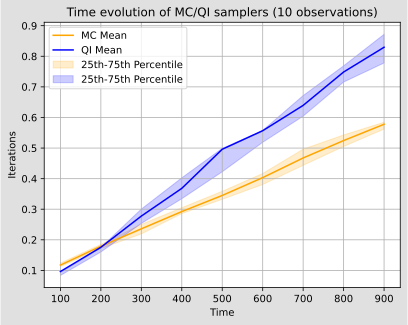

In [15]:
mc1_mean = np.mean(mc1_time, axis=0)
mc1_percentile_25 = np.percentile(mc1_time, 25, axis=0)
mc1_percentile_75 = np.percentile(mc1_time, 75, axis=0)

qinf1_mean = np.mean(qinf1_time, axis=0)
qinf1_percentile_25 = np.percentile(qinf1_time, 25, axis=0)
qinf1_percentile_75 = np.percentile(qinf1_time, 75, axis=0)


plt.plot(value_range, mc1_mean, label='MC Mean', color='orange')
plt.plot(value_range, qinf1_mean, label='QI Mean', color='blue')

plt.fill_between(value_range, mc1_percentile_25, mc1_percentile_75, color='orange', alpha=0.2, label='25th-75th Percentile')
plt.fill_between(value_range, qinf1_percentile_25, qinf1_percentile_75, color='blue', alpha=0.2, label='25th-75th Percentile')

plt.xlabel('Time')
plt.ylabel('Iterations')
plt.title(f'Time evolution of MC/QI samplers ({nb_obs} observations)')
plt.legend()
plt.grid(True)

plt.savefig('TimeEvoIter.png')
plt.show()

In [22]:
value_range = range(100, 1001 ,100)
nb_obs = 10
iter = 200

In [23]:

qinf_run_time_list = list()
qinf_proba_err_list = list()

for j in range(nb_obs):

    qinf_run_time_list.append(list())
    qinf_proba_err_list.append(list())

    for i in value_range:
        bn = gum.fastBN("A->B<-C", 2)
        bn.cpt("C")[:] = [i**(-1/2), 1-i**(-1/2)]
        bn.cpt("A")[:] = [i**(-1/2), 1-i**(-1/2)]
        bn.cpt("B")[:] = [[[0.3,0.7],[0.4,0.6]],[[0.5,0.5],[0.6,0.4]]]
        evidence = {"A": 0, "C": 0}
        target = "B"

        ie = gum.LazyPropagation(bn)
        ie.setEvidence(evidence)
        ie.makeInference()

        qbn = qBayesNet(bn)

        qinf = qInference(qbn)
        qinf.setEvidence(evidence)
        qinf.getGates()
        qinf.setMaxIter(iter)
        qinf.makeInference()

        qrt = qRuntime(qinf, backend)
        run_time = qrt.rejectionSamplingRuntime()

        error = (qinf.posterior(target).toarray() - ie.posterior(target).toarray()).max()

        print(f"i: {i}, P(e): {ie.evidenceProbability():.10f}, log: {qinf.log}, runtime: {run_time:.5f}, error: {error}")

        qinf_run_time_list[j].append(run_time)
        qinf_proba_err_list[j].append(error)

qinf_run_time_list = np.array(qinf_run_time_list)
qinf_proba_err_list = np.array(qinf_proba_err_list)

i: 100, P(e): 0.0100000000, log: {'A': 576, 'G': 1214}, runtime: 0.08003, error: 0.05000000000000021
i: 200, P(e): 0.0050000000, log: {'A': 678, 'G': 1928}, runtime: 0.11673, error: 0.0400000000000002
i: 300, P(e): 0.0033333333, log: {'A': 772, 'G': 3102}, runtime: 0.17463, error: 5.551115123125783e-16
i: 400, P(e): 0.0025000000, log: {'A': 785, 'G': 3881}, runtime: 0.20962, error: 0.015000000000000568
i: 500, P(e): 0.0020000000, log: {'A': 820, 'G': 3354}, runtime: 0.18735, error: 0.01500000000000018
i: 600, P(e): 0.0016666667, log: {'A': 859, 'G': 4423}, runtime: 0.23733, error: 0.0500000000000006
i: 700, P(e): 0.0014285714, log: {'A': 899, 'G': 4847}, runtime: 0.25807, error: 0.020000000000000573
i: 800, P(e): 0.0012500000, log: {'A': 896, 'G': 4682}, runtime: 0.25070, error: 0.0050000000000005596
i: 900, P(e): 0.0011111111, log: {'A': 925, 'G': 5859}, runtime: 0.30496, error: 0.020000000000000573
i: 1000, P(e): 0.0010000000, log: {'A': 949, 'G': 5495}, runtime: 0.28996, error: 0.05

In [24]:
mc_run_time_list = list()
mc_proba_err_list = list()

ev_proba_list = list()

for j in range(nb_obs):

    mc_run_time_list.append(list())
    mc_proba_err_list.append(list())
    ev_proba_list.append(list())

    for i in value_range:
        bn = gum.fastBN("A->B<-C", 2)
        bn.cpt("C")[:] = [i**(-1/2), 1-i**(-1/2)]
        bn.cpt("A")[:] = [i**(-1/2), 1-i**(-1/2)]
        bn.cpt("B")[:] = [[[0.3,0.7],[0.4,0.6]],[[0.5,0.5],[0.6,0.4]]]
        evidence = {"A": 0, "C": 0}
        target = "B"

        ie = gum.LazyPropagation(bn)
        ie.setEvidence(evidence)
        ie.makeInference()

        mc = gum.MonteCarloSampling(bn)

        mc.setEvidence(evidence)
        mc.setEpsilon(1e-10)
        mc.setMaxTime(1e10)
        mc.setMaxIter(iter)
        mc.makeInference()

        run_time = mc.currentTime()

        error = (mc.posterior(target).toarray() - ie.posterior(target).toarray()).max()

        print(f"i: {i}, P(e): {ie.evidenceProbability():.10f}, runtime: {run_time:.5f}, error: {error}")

        mc_run_time_list[j].append(run_time)
        mc_proba_err_list[j].append(error)

        ev_proba_list[j].append(ie.evidenceProbability())

ev_proba_list = ev_proba_list[0]

mc_run_time_list = np.array(mc_run_time_list)
mc_proba_err_list = np.array(mc_proba_err_list)

i: 100, P(e): 0.0100000000, runtime: 0.05228, error: 0.026666666666666727
i: 200, P(e): 0.0050000000, runtime: 0.07919, error: 0.0033333333333334103
i: 300, P(e): 0.0033333333, runtime: 0.13425, error: 0.023333333333333428
i: 400, P(e): 0.0025000000, runtime: 0.15242, error: 0.010000000000000009
i: 500, P(e): 0.0020000000, runtime: 0.22132, error: 0.006666666666666654
i: 600, P(e): 0.0016666667, runtime: 0.26507, error: 0.043333333333333335
i: 700, P(e): 0.0014285714, runtime: 0.27195, error: 0.01666666666666672
i: 800, P(e): 0.0012500000, runtime: 0.37484, error: 0.006666666666666654
i: 900, P(e): 0.0011111111, runtime: 0.40888, error: 0.0033333333333334103
i: 1000, P(e): 0.0010000000, runtime: 0.39275, error: 0.030000000000000027
i: 100, P(e): 0.0100000000, runtime: 0.04911, error: 0.013333333333333364
i: 200, P(e): 0.0050000000, runtime: 0.08971, error: 0.0
i: 300, P(e): 0.0033333333, runtime: 0.13742, error: 0.043333333333333335
i: 400, P(e): 0.0025000000, runtime: 0.16116, error: 

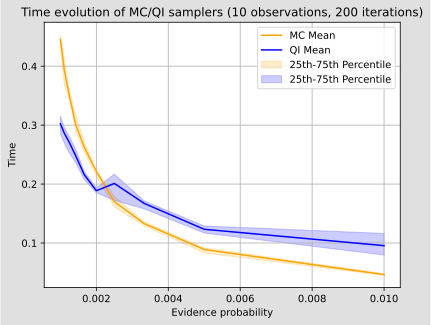

In [25]:
mc1_mean = np.mean(mc_run_time_list, axis=0)
mc1_percentile_25 = np.percentile(mc_run_time_list, 25, axis=0)
mc1_percentile_75 = np.percentile(mc_run_time_list, 75, axis=0)

qinf1_mean = np.mean(qinf_run_time_list, axis=0)
qinf1_percentile_25 = np.percentile(qinf_run_time_list, 25, axis=0)
qinf1_percentile_75 = np.percentile(qinf_run_time_list, 75, axis=0)

plt.plot(ev_proba_list, mc1_mean, label='MC Mean', color='orange')
plt.plot(ev_proba_list, qinf1_mean, label='QI Mean', color='blue')

plt.fill_between(ev_proba_list, mc1_percentile_25, mc1_percentile_75, color='orange', alpha=0.2, label='25th-75th Percentile')
plt.fill_between(ev_proba_list, qinf1_percentile_25, qinf1_percentile_75, color='blue', alpha=0.2, label='25th-75th Percentile')

plt.xlabel('Evidence probability')
plt.ylabel('Time')
plt.title(f'Time evolution of MC/QI samplers ({nb_obs} observations, {iter} iterations)')
plt.legend()
plt.grid(True)

plt.savefig('TimeEvoProb.png')
plt.show()

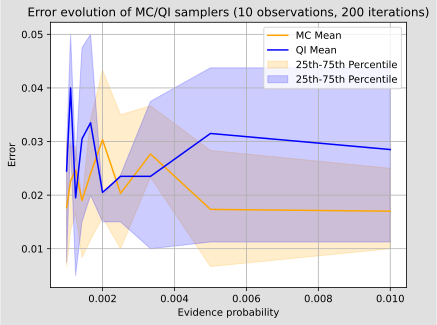

In [26]:
mc1_mean = np.mean(mc_proba_err_list, axis=0)
mc1_percentile_25 = np.percentile(mc_proba_err_list, 25, axis=0)
mc1_percentile_75 = np.percentile(mc_proba_err_list, 75, axis=0)

qinf1_mean = np.mean(qinf_proba_err_list, axis=0)
qinf1_percentile_25 = np.percentile(qinf_proba_err_list, 25, axis=0)
qinf1_percentile_75 = np.percentile(qinf_proba_err_list, 75, axis=0)

plt.plot(ev_proba_list, mc1_mean, label='MC Mean', color='orange')
plt.plot(ev_proba_list, qinf1_mean, label='QI Mean', color='blue')

plt.fill_between(ev_proba_list, mc1_percentile_25, mc1_percentile_75, color='orange', alpha=0.2, label='25th-75th Percentile')
plt.fill_between(ev_proba_list, qinf1_percentile_25, qinf1_percentile_75, color='blue', alpha=0.2, label='25th-75th Percentile')

plt.xlabel('Evidence probability')
plt.ylabel('Error')
plt.title(f'Error evolution of MC/QI samplers ({nb_obs} observations, {iter} iterations)')
plt.legend()
plt.grid(True)

plt.savefig('ErrEvoProb.png')
plt.show()